In [3]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.model_selection import GridSearchCV
import gc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

# Preparing the data

In [5]:
# download the data

df_01 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-01.parquet')
df_02 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-02.parquet')
df_03 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-03.parquet')
df_04 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-04.parquet')
df_05 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-05.parquet')
df_06 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-06.parquet')
df_07 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-07.parquet')
df_08 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-08.parquet')
df_09 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-09.parquet')
df_10 = pd.read_parquet('//kaggle/input/nyc-taxi/yellow_tripdata_2022-10.parquet')
df_11 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-11.parquet')
df_12 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-12.parquet')

In [6]:
# converting the format

dfs = [df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12]
float_columns = ['trip_distance','fare_amount', 'extra', 'mta_tax',
                 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
int_columns = ['VendorID', 'PULocationID', 'DOLocationID', 'payment_type', 'passenger_count', 'RatecodeID']
dt_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

for df in dfs:
  df.fillna(0, inplace=True)
  df[float_columns] = df[float_columns].astype('float32')
  df[int_columns] = df[int_columns].astype('uint16')

In [7]:
# stacking the datasets together

df = pd.concat(dfs, ignore_index=True)

# deleting the unnecessary dataframes

for df_i in dfs:
  del df_i

# Feature engineering and data preprocessing

In [8]:
# drop unnecessary features

df.drop(['RatecodeID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'VendorID'], axis=1, inplace=True)

In [9]:
# drop irrelevant years

df['year'] = df['tpep_pickup_datetime'].apply(lambda x: x.year)
df.drop(df[df['year'] != 2022].index, axis=0, inplace=True)
df.drop('year', axis=1, inplace=True)

In [11]:
# extracting timestamp features

df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['month'] = df['tpep_pickup_datetime'].dt.month
df['day_of_year'] = df['tpep_pickup_datetime'].dt.dayofyear
df['week'] = df['tpep_pickup_datetime'].apply(lambda x: x.isocalendar()[1])

american_holidays = calendar().holidays()
df['is_holiday'] = df['tpep_pickup_datetime'].dt.date.isin(american_holidays)
df['is_18th_sep'] = (df['day_of_year'] == 261).astype(int)
df['is_29th_jan'] = (df['day_of_year'] == 29).astype(int)

# traffic time
df['traffic_time'] = (
    (df['day_of_week'].isin(['Friday', 'Saturday', 'Sunday', 'Monday'])) &
    ((df['pickup_hour'].between(8, 18)) | ((df['pickup_hour'].between(8, 17)) & (df['day_of_week'] == 'Monday')))
).astype(int)

# free road time
df['freeroad_time'] = (
    ((df['day_of_week'].isin(['Monday', 'Tuesday'])) & (df['pickup_hour'].between(4, 5))) |
    ((df['day_of_week'].isin(['Wednesday', 'Thursday'])) & (df['pickup_hour'].between(5, 6))) |
    ((df['day_of_week'].isin(['Friday', 'Saturday', 'Sunday'])) & (df['pickup_hour'] == 4))
).astype(int)

df_train.drop('tpep_pickup_datetime', axis=1, inplace=True)
df_test.drop('tpep_pickup_datetime', axis=1, inplace=True)

In [16]:
# removing the outliers from the trip distance

df.drop(df[df['trip_distance'] > 70].index, axis=0, inplace=True)
df['log_trip_distance'] = np.log1p(df['trip_distance'])
df.drop('trip_distance', axis=1, inplace=True)

In [12]:
# extarcting the target

df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
df.drop('tpep_dropoff_datetime', axis=1, inplace=True)

In [13]:
# training and test data split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=69)
del df

In [15]:
# removing the outliers from the trip duration
# drop too short trips
df_train.drop(df_train[df_train['trip_duration'] < 120].index, axis=0, inplace=True)

# drop too long trips
df_train.drop(df_train[df_train['trip_duration'] > df_train['trip_duration'].quantile(0.99)].index, axis=0, inplace=True)

In [17]:
# log values

df_train['log_trip_duration'] = np.log1p(df_train['trip_duration'])
df_train.drop(['trip_duration', 'trip_distance'], axis=1, inplace=True)

In [21]:
# Create a new column combining PULocationID and DOLocationID as tuples
df_train['LocationPairs'] = list(zip(df_train['PULocationID'], df_train['DOLocationID']))

# Get the 100 most frequent cooccurrences
top_cooccurrences = df_train['LocationPairs'].value_counts().head(100).index

# Create a binary feature indicating whether the pair is among the top 100
df_train['is_100_location_pair'] = df_train['LocationPairs'].isin(top_cooccurrences).astype(int)

# Drop the temporary 'LocationPairs' column
df_train = df_train.drop('LocationPairs', axis=1)

# Create a new column combining PULocationID and DOLocationID as tuples
df_test['LocationPairs'] = list(zip(df_test['PULocationID'], df_test['DOLocationID']))

# Create a binary feature indicating whether the pair is among the top 100
df_test['is_100_location_pair'] = df_test['LocationPairs'].isin(top_cooccurrences).astype(int)

# Drop the temporary 'LocationPairs' column
df_test = df_test.drop('LocationPairs', axis=1)

df_train.drop(['PULocationID', 'DOLocationID'], axis=1, inplace=True)
df_test.drop(['PULocationID', 'DOLocationID'], axis=1, inplace=True)

In [28]:
# converting the format

float16_columns = ['log_trip_duration','log_trip_distance']
uint8_columns = ['pickup_hour', 'month', 'week', 'day_of_week', 'passenger_count']
uint16_columns = ['day_of_year']
bool_columns = ['is_18th_sep', 'is_29th_jan', 'traffic_time', 'freeroad_time', 'is_100_location_pair']

df_train[float16_columns] = df_train[float16_columns].astype('float16')
df_train[uint8_columns] = df_train[uint8_columns].astype('uint8')
df_train[uint16_columns] = df_train[uint16_columns].astype('uint16')
df_train[bool_columns] = df_train[bool_columns].astype('bool')

In [32]:
df_train.head()

,passenger_count,day_of_week,pickup_hour,month,day_of_year,week,is_holiday,is_18th_sep,is_29th_jan,log_trip_duration,log_trip_distance,traffic_time,freeroad_time,is_100_location_pair
28144837,1,2,10,9,264,38,False,False,False,8.109,2.764,False,False,False
29046917,1,3,18,9,272,39,False,False,False,5.656,0.647,False,False,False
20637983,6,6,4,7,191,27,False,False,False,5.285,0.737,False,False,False
33084743,1,1,18,11,305,44,False,False,False,6.695,0.693,False,False,True
21648289,1,1,23,7,200,29,False,False,False,7.527,1.849,False,False,False


In [31]:
df_test['trip_duration'].describe()

count   11895951.000
mean        1039.072
std         2911.248
min       -83852.000
25%          446.000
50%          736.000
75%         1194.000
max       510791.000
Name: trip_duration, dtype: float64

In [33]:
# converting the format

float16_columns = ['log_trip_distance']
float32_columns = ['trip_duration']
uint8_columns = ['passenger_count', 'pickup_hour', 'month', 'week', 'day_of_week']
uint16_columns = ['day_of_year']
bool_columns = ['is_18th_sep', 'is_29th_jan', 'traffic_time', 'freeroad_time', 'is_100_location_pair']

df_test[float16_columns] = df_test[float16_columns].astype('float16')
df_test[float32_columns] = df_test[float32_columns].astype('float32')
df_test[uint8_columns] = df_test[uint8_columns].astype('uint8')
df_test[uint16_columns] = df_test[uint16_columns].astype('uint16')
df_test[bool_columns] = df_test[bool_columns].astype('bool')

In [35]:
df_test.head()

,passenger_count,day_of_week,pickup_hour,month,day_of_year,week,is_holiday,is_18th_sep,is_29th_jan,trip_duration,log_trip_distance,traffic_time,freeroad_time,is_100_location_pair
32778910,1,0,6,10,304,44,False,False,False,380.000,0.775,False,False,False
20622906,2,5,23,7,190,27,False,False,False,1114.000,1.641,False,False,False
12336908,1,4,11,4,119,17,False,False,False,1276.000,1.153,False,False,False
24163761,1,4,18,8,224,32,False,False,False,493.000,1.068,False,False,False
28548608,2,5,23,9,267,38,False,False,False,858.000,1.490,False,False,False


# Modeling

## LGBM

In [60]:
# LGBM gridsearch

lgbm_grid = {'n_estimators': [100, 200, 300, 500]}
lgbm_cv = GridSearchCV(LGBMRegressor(), lgbm_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', refit=True)

In [62]:
lgbm_cv.fit(df_train.drop('log_trip_duration', axis=1), df_train['log_trip_duration'])
y_pred_lgbm = lgbm_cv.predict(df_test.drop('trip_duration', axis=1))

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 500]},
             scoring='neg_root_mean_squared_error')

In [67]:
lgbm_error = RMSE(df_test['trip_duration'], np.exp(y_pred_lgbm)-1, squared=False)
lgbm_error

2830.9650498973283

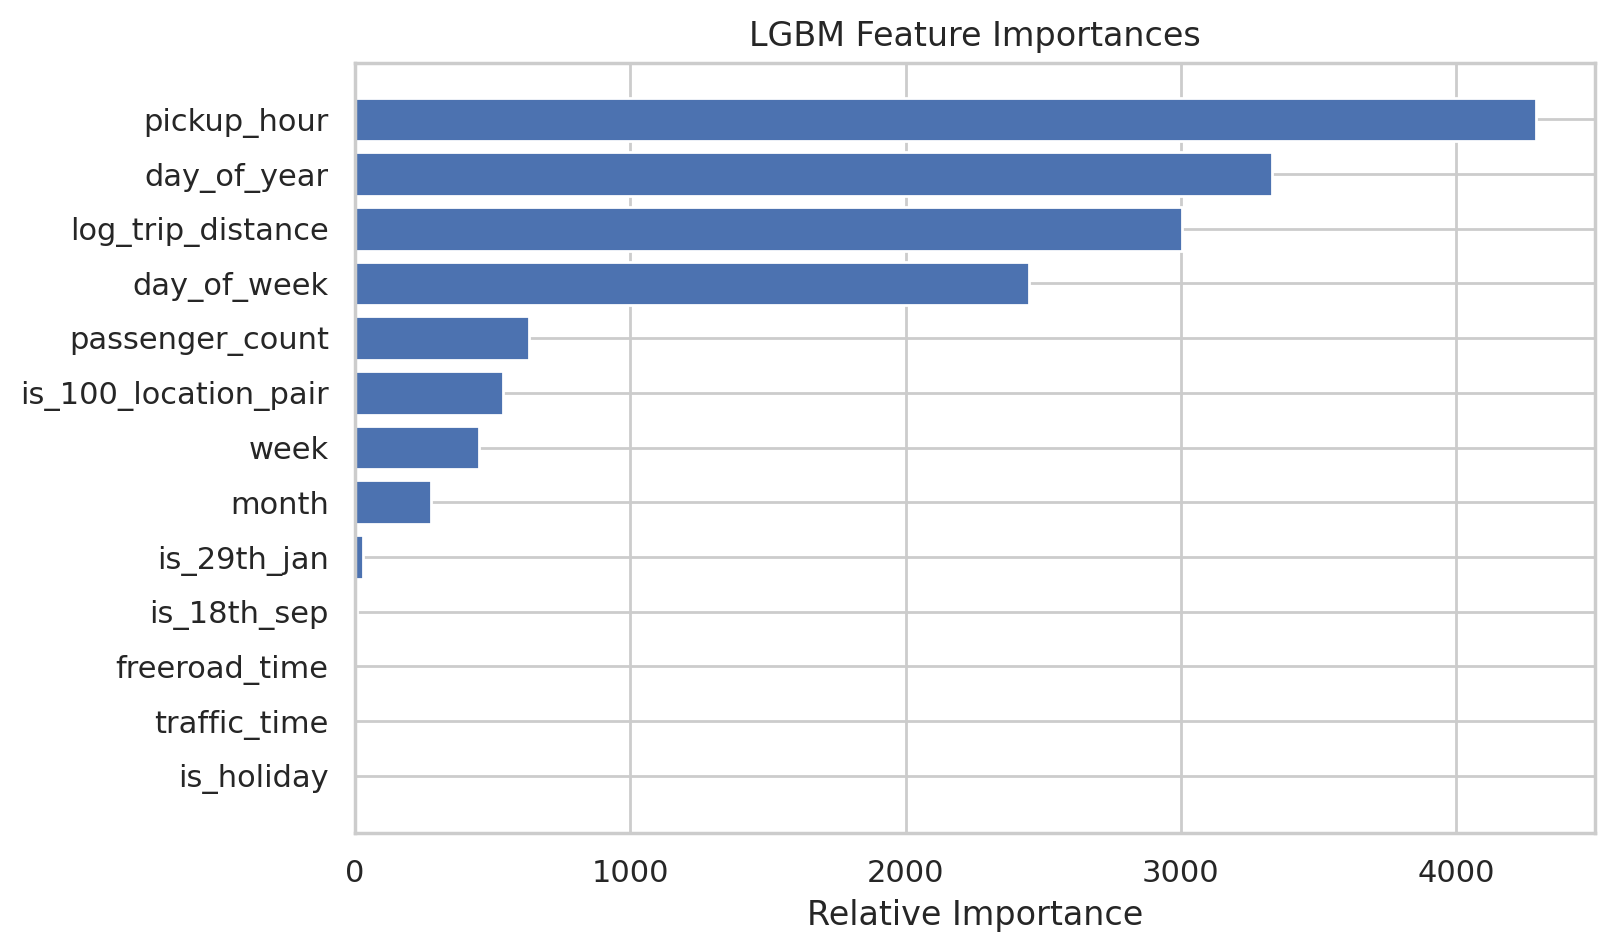

In [80]:
lgbm = LGBMRegressor(n_estimators=500)
lgbm.fit(df_train.drop('log_trip_duration', axis=1), df_train['log_trip_duration'])

lgbm_imps = pd.DataFrame({'Features': df_train.drop('log_trip_duration', axis=1).columns, 'Importance': lgbm.feature_importances_})
lgbm_imps.sort_values(by='Importance', inplace=True)

plt.barh(lgbm_imps['Features'], lgbm_imps['Importance'])
plt.xlabel('Relative Importance')
plt.title('LGBM Feature Importances')
plt.show()

## Ridge regression

In [50]:
# ridge regression gridsearch

ridge_grid = {'alpha': [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]}
ridge_cv = GridSearchCV(Ridge(), ridge_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', refit=True)

In [51]:
ridge_cv.fit(df_train.drop('log_trip_duration', axis=1), df_train['log_trip_duration'])
y_pred_ridge = ridge_cv.predict(df_test.drop('trip_duration', axis=1))

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]},
             scoring='neg_root_mean_squared_error')

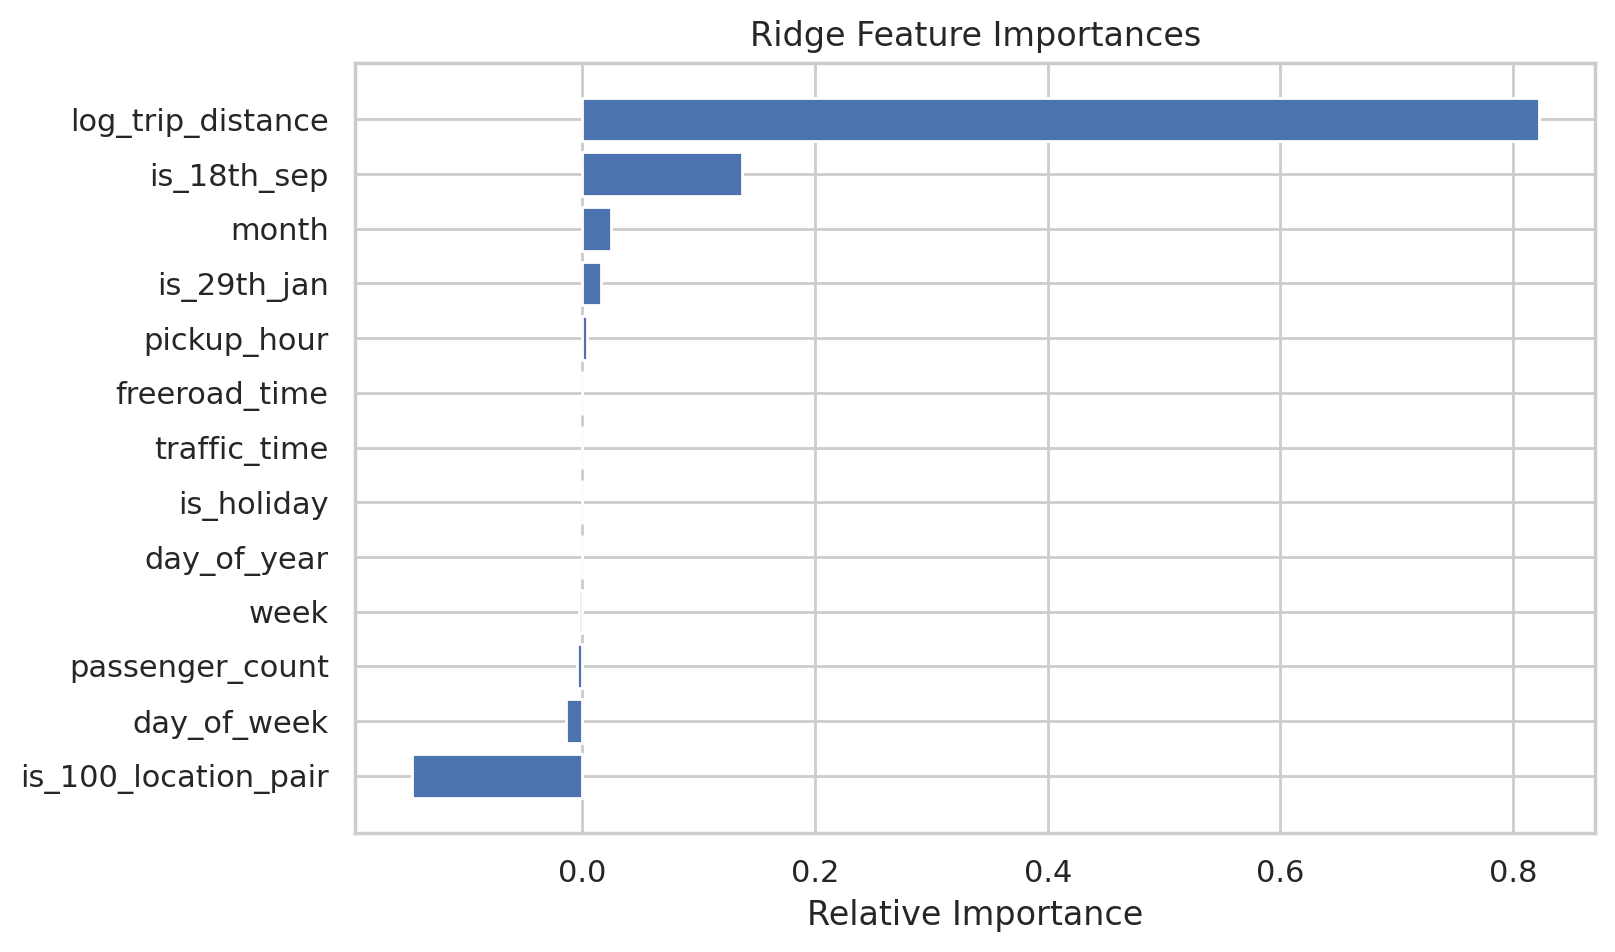

In [77]:
ridge = Ridge(alpha=0.1)
ridge.fit(df_train.drop('log_trip_duration', axis=1), df_train['log_trip_duration'])

ridge_coefs = pd.DataFrame({'Features': df_train.drop('log_trip_duration', axis=1).columns, 'Importance': ridge.coef_})
ridge_coefs.sort_values(by='Importance', inplace=True)

plt.barh(ridge_coefs['Features'], ridge_coefs['Importance'])
plt.xlabel('Relative Importance')
plt.title('Ridge Feature Importances')
plt.show()

In [54]:
ridge_error = RMSE(df_test['trip_duration'], np.exp(y_pred_ridge)-1, squared=False)
ridge_error

2843.3635